In [1]:
include("../path.jl")
include("../ToolBox/ToolBox.jl")
using .ToolBox
using .Geometry

┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1186
┌ Warning: Module MacroTools with build ID 12047338851717 is missing from the cache.
│ This may mean MacroTools [1914dd2f-81c6-5fcd-8719-6d5c9610ff09] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [2]:
function coregister_slave2(master_view,slave_data_path,meta,precise_orbit,dem,stride=(2,8))
    # get some coficents
    c = 299792458
    range_pixel_spacing =  c/(2*meta[1]["range_sampling_rate"])
    lambda =  c/meta[1]["radar_frequency"]

    # Get the midburst speed
    v_mid = mid_burst_speed(precise_orbit[2], meta[2]);

    # look_up_table
    mosaic_view = SlcUtil.mosaic_view(meta[1],master_view)
    lut = look_up_table(mosaic_view,meta,precise_orbit,dem,stride=(2,8))

    # get master line and sample
    master_line, master_sample = Misc.flatten(mosaic_view...)

    # interpolate slave line and sample
    slave_line = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
    reshape(lut["slave_line"],(length(lut["master_line"]),length(lut["master_sample"])))
    ,mosaic_view[1], mosaic_view[2])
    slave_sample = Misc.interp_grid(lut["master_line"] ,lut["master_sample"],
        reshape(lut["slave_sample"],(length(lut["master_line"]),length(lut["master_sample"])))
        ,mosaic_view[1], mosaic_view[2]);

    slave_line = reshape(slave_line,:)
    slave_sample= reshape(slave_sample,:);

    # master bursts
    master_start_burst = ceil(Int,(master_view[1].start)/meta[1]["lines_per_burst"])
    master_end_burst = ceil(Int,(master_view[1].stop-1)/meta[1]["lines_per_burst"])

    # find the slave bursts
    slave_start_line = minimum(slave_line)
    slave_start_burst = sum([slave_start_line > elem ? 1 : 0 for elem in meta[2]["burst_meta"]["first_line_mosaic"]])

    ## Get the number of lines in the first selected burst
    lines_in_first_burst_master = master_start_burst*meta[1]["lines_per_burst"] - master_view[1].start
    lines_in_first_burst_slave = meta[2]["burst_meta"]["first_line_mosaic"][slave_start_burst]+meta[2]["lines_per_burst"] - slave_start_line

    ## Check if the number of lines are approximately the same
    if lines_in_first_burst_slave > lines_in_first_burst_master + 100
        # the number of lines are not the same. The slave burst before should be included
        slave_start_burst = slave_start_burst -1
        lines_in_first_burst_slave = slave_start_burst*meta[2]["lines_per_burst"] - slave_start_line
    end

    # compute the offset between the burst number in slave and master
    delta_burst = slave_start_burst - master_start_burst

    ## check if it is in slave image
    slave_end_burst = master_end_burst + delta_burst

    if slave_start_burst == 0
        println("Warning: start line not in slave image")
    end

    if slave_end_burst > meta[2]["burst_count"]
        println("Warning: end line not in slave image")
    end

    if minimum(slave_sample) < 1
        println("Warning: start sample not in slave image")
    end

    if maximum(slave_sample) > meta[2]["samples_per_burst"]
        println("Warning: end sample not in slave image")
    end

    # Initialize arrays for the results
    coreg_slave = Array{Complex{Float64}}(undef,length.(master_view)...)
    flat_inferogram = Array{Complex{Float64}}(undef,length.(master_view)...)

    # load and resample one burst at a time
    for n_master in master_start_burst:master_end_burst

        n_slave =  n_master + delta_burst

        start_line_master = meta[1]["lines_per_burst"] * (n_master-1)+1
        end_line_master = meta[1]["lines_per_burst"] * n_master

        ## offset cused by overlap between burts
        over_lap_master = meta[1]["lines_per_burst"]*(n_master-1)+1 - meta[1]["burst_meta"]["first_line_mosaic"][n_master]
        over_lap_slave = meta[2]["lines_per_burst"]*(n_slave-1)+1 - meta[2]["burst_meta"]["first_line_mosaic"][n_slave]

        if n_master == master_start_burst
            start_line_master = master_view[1].start
        end

        if n_master == master_end_burst
            end_line_master = master_view[1].stop
        end

        # finds the lines in the burst
        in_burst = (start_line_master-over_lap_master) .<= master_line .<= (end_line_master-over_lap_master)


        # get lines
        master_line_n = master_line[in_burst] .+ over_lap_master
        slave_line_n = slave_line[in_burst] .+ over_lap_slave

        # get samples
        master_sample_n = master_sample[in_burst]
        slave_sample_n = slave_sample[in_burst]

        # load data
        slave_view_n = round(Int,minimum(slave_line_n)): round(Int,maximum(slave_line_n)),
                    round(Int,minimum(slave_sample_n)): round(Int,maximum(slave_sample_n))
        slave_data = Load.slc_data(slave_data_path, slave_view_n);

        # deramp
        #phi = SlcUtil.phase_ramp(Misc.flatten(slave_view_n...)..., n_slave, meta[2], v_mid[n_slave]);
        # slave_data = slave_data .* reshape(exp.(-phi .* im),size(slave_data));

        # dimension of resample
        dim = (convert(Int,length(master_line_n)/length(master_view[2])),length(master_view[2]))

        #resample
        slave_data = Misc.resample(slave_view_n,slave_data,slave_line_n,slave_sample_n)
        slave_data = reshape(slave_data, dim);

        # reramp
        #phi = SlcUtil.phase_ramp(slave_line_n, slave_sample_n, n_slave, meta[2], v_mid[n_slave])
        #slave_data = slave_data .* reshape(exp.(phi .* im),dim);

        # flat_inferogram
        flat = exp.(4*pi.*(master_sample_n.-slave_sample_n).*range_pixel_spacing./lambda.*im)
        flat = reshape(flat,dim);

        # store results
        coreg_slave[(start_line_master:end_line_master) .- (master_view[1].start-1),:] .= slave_data
        flat_inferogram[(start_line_master:end_line_master) .- (master_view[1].start-1),:] .= flat
    end

    # remove the slave goemtry and return the dict as geo_ref_table
    delete!(lut, "slave_sample")
    delete!(lut, "slave_line")
    geo_ref_table = lut

    return coreg_slave, flat_inferogram, geo_ref_table
end

coregister_slave2 (generic function with 2 methods)

In [3]:
master_view = [2000:6000,1000:9000]
small = 5001:8001

5001:8001

In [4]:
# load meta and pod
master_meta = Load.slc_meta(master_meta_path);
master_precise_orbit = Load.precise_orbit(master_pod_path,master_meta["t_0"]);
slave_meta = Load.slc_meta(slave_meta_path);
slave_precise_orbit = Load.precise_orbit(slave_pod_path,slave_meta["t_0"]);

In [5]:
meta = (master_meta,slave_meta)
precise_orbit = (master_precise_orbit,slave_precise_orbit);

In [6]:
# load DEM
footprint = SlcUtil.footprint(master_meta, master_view)
latlon_window = ((minimum(footprint[1]),maximum(footprint[1])),(minimum(footprint[2]),maximum(footprint[2])))
dem = Load.dem(dem_path, latlon_window; nan_fill= 0, padding=[90,90]);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [7]:
slave_data, flat, lut =  coregister_slave2(master_view,slave_data_path,meta,precise_orbit,dem);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [8]:
master_data = Load.slc_data(master_data_path, master_view);
#master_data, mosaic_view = SlcUtil.mosaic(master_data, master_view, meta[1]);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


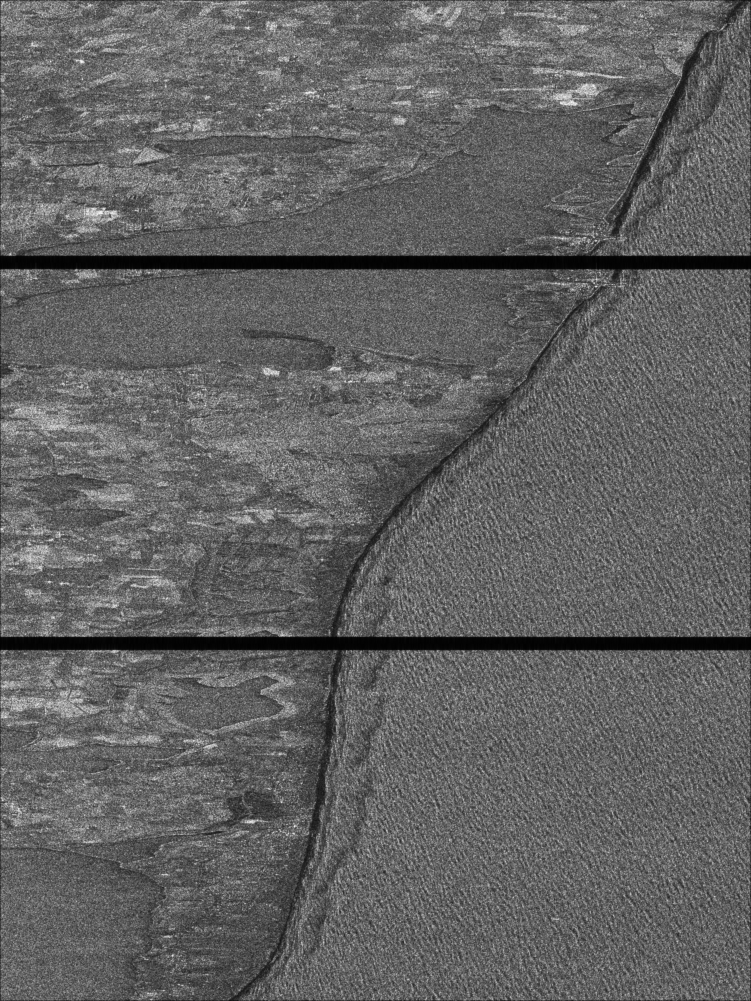

In [9]:
#SlcUtil.show_img(master_data[:,small])

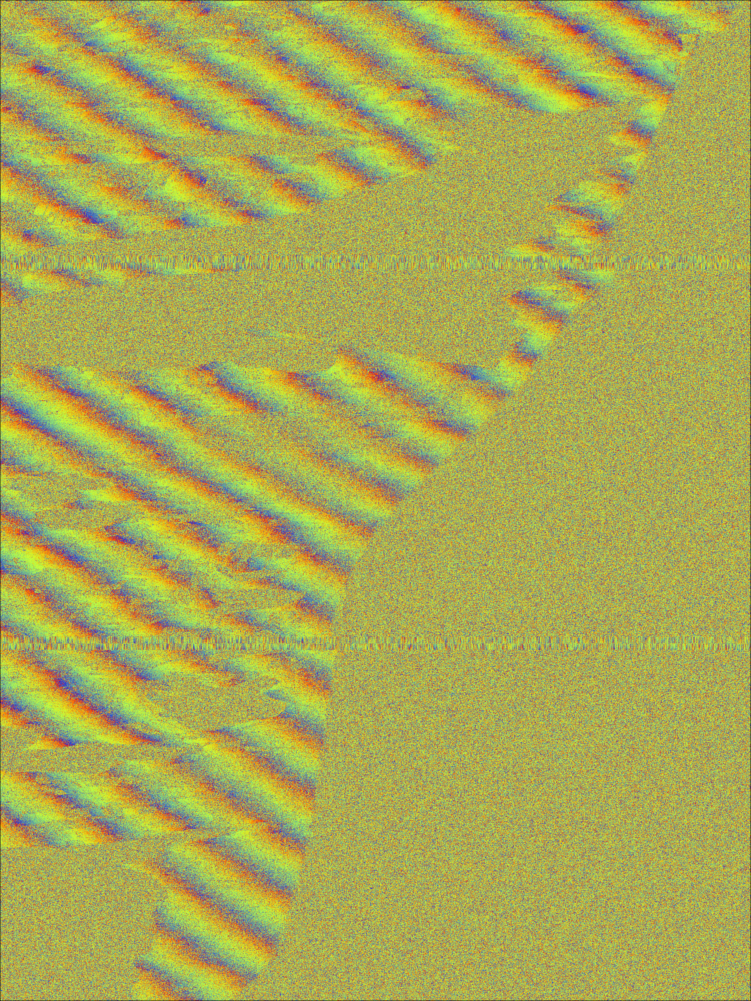

In [10]:
SlcUtil.plot_phase(master_data[:,small] .* conj.(slave_data[:,small]) .* flat[:,small])

In [11]:
SlcUtil._phase_colorbar()

 -π                 -π/2                 0                 π/2                 π


In [12]:
import FileIO
FileIO.save("intfgr_all.jpg", SlcUtil.plot_phase(master_data[:,small] .* conj.(slave_data[:,small])))
FileIO.save("intfgr_rm_flat.jpg", SlcUtil.plot_phase(master_data[:,small] .* conj.(slave_data[:,small]) .* flat[:,small] ))

In [13]:
slave_data, flat, lut =  coregister_slave(master_view, slave_data_path, meta, precise_orbit,dem);

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


In [14]:
FileIO.save("intfgr_rm_flat_deramp.jpg", SlcUtil.plot_phase(master_data[:,small] .* conj.(slave_data[:,small]) .* flat[:,small] ))